# 0. Importanción de librerías

Importamos las librerías importantes

In [1]:
# Librerías principales
import os
import time
import numpy as np
import scipy.io as sio
import math
import matplotlib.pyplot as plt
import tensorflow as tf

# Librerías de tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, Flatten 
from tensorflow.keras.layers import Add, Concatenate, Lambda, Input, Permute
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense
from tensorflow.keras.layers import multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras.layers import Dropout, MultiHeadAttention, LayerNormalization, Reshape
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# Librerías de scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from scipy.signal import butter, filtfilt

# 1. Pre-procesamiento de la data

Definimos funciones para graficar las curvas de aprendizaje, las matrices de confusión y los gráficos de barras de rendimiento.

In [2]:
def draw_learning_curves(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Val"], loc="upper left")
    plt.show()
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Val"], loc="upper left")
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path):
    display_labels = ["Left hand", "Right hand","Foot","Tongue"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cf_matrix,
        display_labels=display_labels
    )
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title("Confusion Matrix of Subject: " + sub )
    plt.savefig(results_path + "/subject_" + sub + ".png")
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title("Model "+ label + " per subject")
    ax.set_ylim([0, 1])

Definimos una función para filtrar las señales de 8 a 40 Hz.

In [20]:
# Define the sampling frequency and the band
fs = 250.0  # Sample frequency (Hz)
lowcut = 1.0  # Low cut frequency of the band-pass filter (Hz)
highcut = 40.0  # High cut frequency of the band-pass filter (Hz)

# Function to create a Butterworth band-pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency, which is half of fs
    low = lowcut / nyq
    high = highcut / nyq
    # b, a = butter(order, [low, high], btype="band")
    b, a = butter(order, low, btype="high")
    return b, a

b, a = butter_bandpass(lowcut, highcut, fs)

# Function to apply the Butterworth band-pass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    y = filtfilt(b, a, data)
    return y


Definimos una función que cargue y divida el dataset con un enfoque específico al sujeto. Esto con la finalidad de mantener la misma data de entrenamiento y testeo que la compentencia original, es decir, 288 x 9 pruebas en la sesión 1 para entrenamiento y 288 x 9 pruebas en la sesión 2 para testeo.

In [21]:
def load_data(data_path, subject, training, all_trials=True):

	# data_path: dirección del dataset
	# subject: número de sujeto
	# training: True para data de entrenamiento y False para data de testeo
	# all_trials: True para cargar todos las pruebas y False para ignorar las que contienen artefactos

    # Definición de las constantes para la extracción de los datos
	n_channels = 22				# Número de canales
	n_tests = 6*48 				# Número de pruebas
	window_Length = 7*250 		# Tamaño de las ventanas en muestras (7 segundos a 250Hz)

	# Inicialización de los arreglos donde se guardarán las clases y los datos
	class_return = np.zeros(n_tests)
	data_return = np.zeros((n_tests, n_channels, window_Length))

	NO_valid_trial = 0

	# Carga del archivo correspondiente, según si es para entrenamiento o prueba
	if training:
		a = sio.loadmat(data_path+"A0"+str(subject)+"T.mat")
	else:
		a = sio.loadmat(data_path+"A0"+str(subject)+"E.mat")

	# Extracción de los datos del archivo
	a_data = a["data"]

	# Bucle para recorrer todas los trials del sujeto
	for ii in range(3, a_data.size):

		# Entramos a la data de interés
		a_data1 = a_data[0, ii]
		a_data2 = [a_data1[0, 0]]
		a_data3 = a_data2[0]

		# Datos de interés
		a_X = a_data3[0]			# Datos EEG del trial
		a_trial = a_data3[1]		# Información del trial
		a_y = a_data3[2]			# Clase del trial
		a_artifacts = a_data3[5]	# Información de artefactos
		a_X_filt = np.zeros(a_X.shape)
		for i in range(a_X.shape[1]):
			a_X_filt[:, i] = butter_bandpass_filter(a_X[:, i], lowcut, highcut, fs)
		a_X = a_X_filt
		# print(a_X.shape)

		# Bucle para recorrer las ventanas del trial
		for trial in range(0, a_trial.size):

			# Si el trial tiene artefactos y no se desean incluir estos trials, se omite
			if(a_artifacts[trial] != 0 and not all_trials):
				continue

			# Si no, se guarda la ventana de datos en data_return y la clase en class_return
			data_return[NO_valid_trial, :, :] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+window_Length), :22])
			class_return[NO_valid_trial] = int(a_y[trial])
			NO_valid_trial += 1

	# Devuelve solo los datos y clases de los trials válidos
	return data_return[0:NO_valid_trial, :, :], class_return[0:NO_valid_trial]

Definimos una función que cargue y divida el dataset con un enfoque de evaluación de "Leave One Subject Out" (LOSO). LOSO se usa para una evaluación independiente del sujeto. En este, el modelo se entrena y evalúa en un número de pliegues igual al número de sujetos, y para cada pliegue, se usa un sujeto como evaluación y los otros como entrenamiento. Este tipo de evaluación asegura que sujetos separados (que no sean visibles para la data de entrenamiento) sean usados para evaluar el modelo.

In [5]:
def load_data_LOSO (data_path, subject):

    # data_path: dirección del dataset
	# subject: número de sujeto que servirá de testeo
    
    # Inicialización de las listas donde se guardarán los datos de entrenamiento
    X_train, y_train = [], []
    
    # Bucle para recorrer todos los sujetos
    for sub in range (0, 9):

        # Creación de la ruta al directorio del sujeto
        path = data_path+"s" + str(sub+1) + "/"
        
        # Carga de los datos de entrenamiento y prueba del sujeto
        X1, y1 = load_data(path, sub+1, True)
        X2, y2 = load_data(path, sub+1, False)

        # Concatenación de los datos de entrenamiento y prueba
        X = np.concatenate((X1, X2), axis=0)
        y = np.concatenate((y1, y2), axis=0)
        
        # Si el sujeto es el seleccionado para pruebas, se guardan sus datos en X_test y y_test
        if (sub == subject):
            X_test = X
            y_test = y
        
        # Si es el primer sujeto de entrenamiento, se inicializan X_train y y_train con sus datos
        elif (X_train == []):
            X_train = X
            y_train = y
        
        # Si no, se concatenan sus datos a X_train y y_train
        else:
            X_train = np.concatenate((X_train, X), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)
    
    # Devolución de los datos de entrenamiento y prueba
    return X_train, y_train, X_test, y_test

Definimos una función para estandarizar los datos.

In [6]:
def standardize_data(X_train, X_test, channels):
    
    # Bucle para recorrer todos los canales
    for j in range(channels):

        # Inicialización del objeto StandardScaler de sklearn
        scaler = StandardScaler()

        # Ajuste del escalador a los datos de entrenamiento del canal j
        scaler.fit(X_train[:, 0, j, :])

        # Transformación de los datos de entrenamiento y prueba del canal j
        X_train[:, 0, j, :] = scaler.transform(X_train[:, 0, j, :])
        X_test[:, 0, j, :] = scaler.transform(X_test[:, 0, j, :])

    # Devolución de los datos de entrenamiento y prueba estandarizados
    return X_train, X_test

Definimos una función para recuperar la data.

In [7]:
def get_data(path, subject, LOSO=False, isStandard=True):

    # Definición de los parámetros del dataset
    fs = 250          # Frecuencia de muestreo
    t1 = int(1.5*fs)  # Punto de inicio en el tiempo
    t2 = int(6*fs)    # Punto final en el tiempo
    T = t2-t1         # Longitud de la prueba de MI (muestras o puntos en el tiempo)
    
    # Carga y división del dataset en entrenamiento y prueba
    if LOSO:

        # Carga y división del dataset basado en el enfoque de evaluación "Leave One Subject Out" (LOSO)
        X_train, y_train, X_test, y_test = load_data_LOSO(path, subject)

    else:
        # Carga y división del dataset basado en el enfoque específico del sujeto. En este enfoque,
        # se utilizan los mismos datos de entrenamiento y prueba que en la competencia original,
        # es decir, pruebas en la sesión 1 para entrenamiento, y pruebas en la sesión 2 para testeo. 
        path = path + "s{:}/".format(subject+1)
        X_train, y_train = load_data(path, subject+1, True)
        X_test, y_test = load_data(path, subject+1, False)

    # Preparación de los datos de entrenamiento
    N_tr, N_ch, _ = X_train.shape 
    X_train = X_train[:, :, t1:t2].reshape(N_tr, 1, N_ch, T)
    y_train_onehot = (y_train-1).astype(int)
    y_train_onehot = to_categorical(y_train_onehot)

    # Preparación de los datos de prueba 
    N_test, N_ch, _ = X_test.shape 
    X_test = X_test[:, :, t1:t2].reshape(N_test, 1, N_ch, T)
    y_test_onehot = (y_test-1).astype(int)
    y_test_onehot = to_categorical(y_test_onehot)	
    
    # Estandarización de los datos
    if (isStandard == True):
        X_train, X_test = standardize_data(X_train, X_test, N_ch)

    return X_train, y_train, y_train_onehot, X_test, y_test, y_test_onehot

# 2. Definición de los bloques del modelo.

Definimos el bloque convolucional (CV). Este se utiliza en la red EEGNet, reemplazando SeparableConv2D con Conv2D. El código original de este modelo está disponible en [GitHub](https://github.com/vlawhern/arl-eegmodels), más detalles en [1](https://arxiv.org/abs/1611.08024).

In [8]:
def Conv_block(input_layer, F1=4, kernLength=64, poolSize=8, D=2, in_chans=22, dropout=0.1):

    # Calcular el número de filtros en la segunda capa convolucional
    F2 = F1*D

    # Bloque 1: Capa convolucional seguida de normalización por lotes
    block1 = Conv2D(F1, (kernLength, 1), padding="same", data_format="channels_last", use_bias=False)(input_layer)
    block1 = BatchNormalization(axis=-1)(block1)

    # Bloque 2: Capa convolucional con multiplicidad de profundidad seguida de normalización
    # por lotes, activación, agrupación de media y dropout
    block2 = DepthwiseConv2D(
        (1, in_chans),
        use_bias=False,
        depth_multiplier=D,
        data_format="channels_last",
        depthwise_constraint=max_norm(1.)
    )(block1)
    block2 = BatchNormalization(axis=-1)(block2)
    block2 = Activation("elu")(block2)
    block2 = AveragePooling2D((8, 1), data_format="channels_last")(block2)
    block2 = Dropout(dropout)(block2)

    # Bloque 3: Capa convolucional seguida de normalización por lotes, activación, agrupación de media y droput
    block3 = Conv2D(F2,
        (16, 1),
        data_format="channels_last",
        use_bias=False,
        padding="same"
    )(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation("elu")(block3)
    block3 = AveragePooling2D((poolSize,1),data_format="channels_last")(block3)
    block3 = Dropout(dropout)(block3)

    # Devolver el resultado del bloque convolucional
    return block3

Definimos el bloque de atención temporal (Multi-head self Attention - MHA). Este contiene dos implementaciones, el original descrito en "Attention Is All You Need" [2](https://arxiv.org/abs/1706.03762), y una implementación local descrita en "Vision Transformer for Small-Size Datasets" [3](https://arxiv.org/abs/2112.13492v1).

In [9]:
def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):

    # Normalizar la capa de entrada
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    
    # Si 'vanilla' es verdadero, aplicar multi-head attention
    if vanilla:
        x = MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    
    # Si 'vanilla' es falso, aplicar multi-head local self-attention
    else:
        
        # Crear una máscara de atención diagonal
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        
        # Aplicar la capa de multi-head local self attention con la máscara de atención creada
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    
    # Aplicar dropout
    x = Dropout(0.3)(x)

    # Añadir conexión de salto (skip connection)
    mha_feature = Add()([input_feature, x])
    
    # Devolver la característica resultante
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Inicializar la temperatura tau como una variable entrenable. 
        # Su valor inicial es la raíz cuadrada de la key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):

        # Modificar la consulta multiplicándola por el inverso de tau
        query = tf.multiply(query, 1.0/self.tau)

        # Calcular las puntuaciones de atención y aplicar softmax enmascarado
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)

        # Aplicar dropout
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)

        # Calcular la salida de la atención
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)

        # Devolver la salida de la atención y las puntuaciones de la atención
        return attention_output, attention_scores

Definimos el bloque de atención Squeeze-and-Excitation (SE). Descrito en "Squeeze-and-Excitation Networks" [4](https://arxiv.org/abs/1709.01507) y la implementación obtenida de [GitHub](https://github.com/kobiso/CBAM-keras).

In [10]:
def se_block(input_feature, ratio=8):

    # Determinar el eje de los canales
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

    # Aplicar la media global de agrupación para obtener una representación de nivel de canal
	se_feature = GlobalAveragePooling2D()(input_feature)

    # Cambiar la forma de la característica a (1, 1, canales)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1, 1, channel)

    # Primera capa densa para aprender interacciones entre canales
	se_feature = Dense(
        channel//ratio,
        activation="relu",
        kernel_initializer="he_normal",
        use_bias=True,
        bias_initializer="zeros"
    )(se_feature)
	assert se_feature.shape[1:] == (1, 1, channel//ratio)

    # Segunda capa densa para aprender a recalibrar cada canal
	se_feature = Dense(
        channel,
        activation="sigmoid",
        kernel_initializer="he_normal",
        use_bias=True,
        bias_initializer="zeros"
    )(se_feature)
	assert se_feature.shape[1:] == (1, 1, channel)

    # Si el formato de los datos es "channels_first", se necesita una permutación
	if K.image_data_format() == "channels_first":
		se_feature = Permute((3, 1, 2))(se_feature)

    # Multiplicar la característica de entrada por la característica de recalibración para obtener la característica de salida
	se_feature = multiply([input_feature, se_feature])

    # Devolver la característica de salida
	return se_feature

Definimos el bloque de atención Convolutional Block Attention Module (CBAM). Descrito en "CBAM: Convolutaionl Block Attention Module" [5](https://arxiv.org/abs/1807.06521) y la implementación obtenida de [GitHub](https://github.com/kobiso/CBAM-keras).

In [11]:
def cbam_block(cbam_feature, ratio=8):

    # Primero se aplica la atención de canal
    cbam_feature = channel_attention(cbam_feature, ratio)

    # Luego se aplica la atención espacial
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):

    # Determina el eje del canal basado en el formato de los datos
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    # Define capas densas compartidas
    shared_layer_one = Dense(channel//ratio, activation="relu", kernel_initializer="he_normal", use_bias=True, bias_initializer="zeros")
    shared_layer_two = Dense(channel, kernel_initializer="he_normal", use_bias=True, bias_initializer="zeros")

    # Calcula la media global y el max pooling, seguido de las capas densas compartidas
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    # Combina los resultados de avg_pool y max_pool, aplica una activación sigmoide y multiplica con la característica de entrada
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation("sigmoid")(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):

    # Define el tamaño del kernel
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    # Calcula la media global y el max pooling, concatena los resultados
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    # Aplica una convolución 2D con una activación sigmoide y multiplica con la característica de entrada
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding="same", activation="sigmoid", kernel_initializer="he_normal", use_bias=False)(concat)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])


Definimos un bloque de atención para aplicar el modelo de atención deseado.

In [12]:
def attention_block(net, attention_model): 
    
    # Obtener las dimensiones del tensor de entrada
    in_sh = net.shape
    in_len = len(in_sh) 
    expanded_axis = 3   # valor por defecto
    
    # Multi-head self attention layer 
    if attention_model == "mha":
        if(in_len > 3):     # Si la dimensión es mayor a 3, cambia la forma a (in_sh[1], -1)
            net = Reshape((in_sh[1], -1))(net)
        # Llama al bloque de atención MHA
        net = mha_block(net)

    # Multi-head local self-attention layer 
    elif attention_model == "mhla":
        if(in_len > 3):
            net = Reshape((in_sh[1], -1))(net)
        # Llama al bloque de atención MHLA
        net = mha_block(net, vanilla=False)
    
    # Squeeze-and-excitation layer
    elif attention_model == "se":
        if(in_len < 4):      # Si la dimensión es menor a 4, expande la dimensión
            net = tf.expand_dims(net, axis=expanded_axis)
        # Llama al bloque de atención SE
        net = se_block(net, ratio=8)
    
    # Convolutional block attention module
    elif attention_model == "cbam":
        if(in_len < 4):
            net = tf.expand_dims(net, axis=expanded_axis)
        # Llama al módulo de atención CBAM
        net = cbam_block(net, ratio=8)
    else:
        # Si el módulo de atención no está soportado, lanza una excepción
        raise Exception("'{}' is not supported attention module!".format(attention_model))
    
    # Ajusta las dimensiones del tensor de salida para que coincida con las dimensiones de entrada
    if (in_len == 3 and len(net.shape) == 4):
        net = K.squeeze(net, expanded_axis)
    elif (in_len == 4 and len(net.shape) == 3):
        net = Reshape((in_sh[1], in_sh[2], in_sh[3]))(net)
    return net

Definimos el bloque convolucional temporal (TCN). Este bloque está descrito en "An empirical evaluation of generic convolutional and recurrent networks for sequence modeling" [6](https://arxiv.org/abs/1803.01271), específicamente una modificación realizada por Ingolfsson en "EEG-TCNet: An Accurate Temporal Convolutional Network for Embedded Motor-Imagery Brain-Machine Interfaces" [7](https://arxiv.org/abs/2006.00622) donde la implementación se encuentra en [GitHub](https://github.com/iis-eth-zurich/eeg-tcnet).

In [13]:
def TCN_block(input_layer, input_dimension, depth, kernel_size, filters, dropout, activation="relu"):
    
    # Aplica la primera convolución causal con activación lineal
    block = Conv1D(
        filters,
        kernel_size=kernel_size,
        dilation_rate=1,
        activation="linear",
        padding="causal",
        kernel_initializer="he_uniform"
    )(input_layer)

    # Aplica la normalización por lotes
    block = BatchNormalization()(block)

    # Aplica la función de activación y la capa dropout
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)

    # Aplica la segunda convolución causal con activación lineal
    block = Conv1D(
        filters,
        kernel_size=kernel_size,
        dilation_rate=1,
        activation="linear",
        padding = "causal",
        kernel_initializer="he_uniform"
    )(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)

    # Si las dimensiones de entrada y salida son diferentes, aplica una convolución 1x1
    if(input_dimension != filters):
        conv = Conv1D(filters, kernel_size=1, padding="same")(input_layer)
        # Suma el resultado de la convolución 1x1 y la segunda convolución causal
        added = Add()([block, conv])
    else:
        # Si las dimensiones son iguales, suma el resultado de la segunda convolución causal y la entrada
        added = Add()([block, input_layer])

    out = Activation(activation)(added)
    
    # Repite el proceso para la profundidad deseada con tasa de dilatación incrementada
    for i in range(depth-1):

        # Repite las mismas operaciones que antes pero aumenta la tasa de dilatación
        block = Conv1D(
            filters,
            kernel_size=kernel_size,
            dilation_rate=2**(i+1),
            activation="linear",
            padding="causal",
            kernel_initializer="he_uniform"
        )(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)

        block = Conv1D(
            filters,
            kernel_size=kernel_size,
            dilation_rate=2**(i+1),
            activation="linear",
            padding="causal",
            kernel_initializer="he_uniform"
        )(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)

        # Suma la salida anterior y la salida actual del bloque
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out

Definimos la arquitectura MMATCNet (Multi-Modal Attention Temporal Convolutional Net). Esta tiene como principal base el modelo ATCNet descrito en "Physics-Informed Attention Temporal Convolutional Network for EEG-Based Motor Imagery Classification" [8](https://ieeexplore.ieee.org/abstract/document/9852687).

In [14]:
def MMATCNet(n_classes, in_chans=22, in_samples=1125, n_windows=3, attention=None, 
           eegn_F1=16, eegn_D=2, eegn_kernelSize=64, eegn_poolSize=8, eegn_dropout=0.3, 
           tcn_depth=2, tcn_kernelSize=4, tcn_filters=32, tcn_dropout=0.3, 
           tcn_activation="elu", fuse="average"):

    # Define el tensor de entrada [None, 1, 22, 1125]
    input_1 = Input(shape = (1, in_chans, in_samples))

    # Permuta las dimensiones de la entrada
    input_2 = Permute((3, 2, 1))(input_1)

    # Parámetros
    regRate = 0.25
    numFilters = eegn_F1
    F2 = numFilters*eegn_D

    # Define el bloque de convolución (basado en EEGNet)
    block1 = Conv_block(
        input_layer=input_2,
        F1=eegn_F1,
        D=eegn_D,
        kernLength=eegn_kernelSize,
        poolSize=eegn_poolSize,
        in_chans=in_chans,
        dropout=eegn_dropout
    )

    # Toma solo la última secuencia del resultado de la convolución
    block1 = Lambda(lambda x: x[:, :, -1, :])(block1)
     
    # Inicializa una lista para almacenar las salidas de las ventanas deslizantes
    sw_concat = []
    for i in range(n_windows):

        # Aplica la ventana deslizante a block1
        block2 = block1[:, i:block1.shape[1]-n_windows+i+1, :]
        
        # Aplica los módulos de atención al bloque 2
        if attention is not None:
            output1 = attention_block(block2, "cbam")
            output2 = attention_block(block2, attention)


        # Define dos bloques TCN, uno para cada salida de atención
        block3_1 = TCN_block(
            input_layer=output1,
            input_dimension=F2,
            depth=tcn_depth,
            kernel_size=tcn_kernelSize,
            filters=tcn_filters,
            dropout=tcn_dropout,
            activation=tcn_activation
        )
        block3_1 = Lambda(lambda x: x[:, -1, :])(block3_1)

        block3_2 = TCN_block(
            input_layer=output2,
            input_dimension=F2,
            depth=tcn_depth,
            kernel_size=tcn_kernelSize,
            filters=tcn_filters,
            dropout=tcn_dropout,
            activation=tcn_activation
        )
        block3_2 = Lambda(lambda x: x[:, -1, :])(block3_2)

        # Combina las salidas de los dos bloques TCN
        block3 = Concatenate()([block3_1, block3_2])
        
        # Depende de la opción de fusión elegida, promedia o concatena la salida de cada ventana
        if(fuse == "average"):
            sw_concat.append(Dense(n_classes, kernel_constraint=max_norm(regRate))(block3))
        elif(fuse == "concat"):
            if i == 0:
                sw_concat = block3
            else:
                sw_concat = Concatenate()([sw_concat, block3])

    # Promedia o aplica una capa densa a la salida final, dependiendo de la opción de fusión           
    if(fuse == "average"):
        if len(sw_concat) > 1: # more than one window
            sw_concat = tf.keras.layers.Average()(sw_concat[:])
        else:
            sw_concat = sw_concat[0]
    elif(fuse == "concat"):
        sw_concat = Dense(n_classes, kernel_constraint=max_norm(regRate))(sw_concat)
            
    # Aplica una activación softmax a la salida final
    softmax = Activation("softmax", name="softmax")(sw_concat)
    
    # Devuelve el modelo
    return Model(inputs=input_1, outputs=softmax)

Generamos una instancia del modelo.

In [15]:
def getModel():

    # Modelo MMATCNet
    model = MMATCNet(

        # Parámetros del dataset
        n_classes = 4, 
        in_chans = 22,
        in_samples = 1125,

        # Parámetro de ventana deslizante
        n_windows = 5,

        # Parámetro del bloque de atención
        attention = "mha", # Opciones: None, "mha","mhla", "cbam", "se"

        # Parámetros del bloque Convolutional (CV)
        eegn_F1 = 16,
        eegn_D = 2, 
        eegn_kernelSize = 64,
        eegn_poolSize = 7,
        eegn_dropout = 0.3,

        # Parámetros del bloque Temporal convolutional (TC)
        tcn_depth = 2, 
        tcn_kernelSize = 4,
        tcn_filters = 32,
        tcn_dropout = 0.3, 
        tcn_activation="elu"
    )

    return model

Definimos una función para el entrenamiento del modelo.

In [16]:
def train(dataset_conf, train_conf, results_path):

    # Get the current "IN" time to calculate the overall training time
    in_exp = time.time()

    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models.txt", "w")

    # Create a file to store performance during training
    log_write = open(results_path + "/log.txt", "w")

    # Create a .npz file (zipped archive) to store the accuracy and kappa metrics 
    # for all runs (to calculate average accuracy/kappa over all runs)
    perf_allRuns = open(results_path + "/perf_allRuns.npz", "wb")
    
    # Get dataset paramters
    n_sub = dataset_conf.get("n_sub")
    data_path = dataset_conf.get("data_path")
    isStandard = dataset_conf.get("isStandard")
    LOSO = dataset_conf.get("LOSO")
    
    # Get training hyperparamters
    batch_size = train_conf.get("batch_size")
    epochs = train_conf.get("epochs")
    patience = train_conf.get("patience")
    lr = train_conf.get("lr")
    LearnCurves = train_conf.get("LearnCurves") # Plot Learning Curves?
    n_train = train_conf.get("n_train")
    model_name = train_conf.get("model")

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))
    
    # Iteration over subjects 
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1, i): for the ith subject.

        # Get the current "IN" time to calculate the subject training time
        in_sub = time.time()
        print("\nTraining on subject ", sub+1)
        log_write.write( "\nTraining on subject "+ str(sub+1) +"\n")

        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0 
        bestTrainingHistory = [] 

        # Get training and test data
        X_train, _, y_train_onehot, X_test, _, y_test_onehot = get_data(
            data_path,
            sub,
            LOSO,
            isStandard
        )
        
        # Iteration over multiple runs 
        for train in range(n_train): # How many repetitions of training for subject i.

            # Get the current "IN" time to calculate the "run" training time
            in_run = time.time()

            # Create folders and files to save trained models for all runs
            filepath = results_path + "/saved models/run-{}".format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)        
            filepath = filepath + "/subject-{}.h5".format(sub+1)
            
            # Create the model
            model = getModel()

            # Compile and train the model
            model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=lr), metrics=["accuracy"])          
            callbacks = [
                ModelCheckpoint(
                    filepath,
                    monitor="val_accuracy",
                    verbose=0,
                    save_best_only=True,
                    save_weights_only=True,
                    mode="max"
                ),
                EarlyStopping(
                    monitor="val_accuracy",
                    verbose=1,
                    mode="max",
                    patience=patience
                )
            ]
            history = model.fit(
                X_train,
                y_train_onehot,
                validation_data=(X_test, y_test_onehot),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=0
            )

            # Evaluate the performance of the trained model. 
            # Here we load the Trained weights from the file saved in the hard 
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_test).argmax(axis=-1)
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)
              
            # Get the current "OUT" time to calculate the "run" training time
            out_run = time.time()

            # Print & write performance measures for each run
            info = "Subject: {}   Train no. {}   Time: {:.1f} m   ".format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + "Test_acc: {:.4f}   Test_kappa: {:.4f}".format(acc[sub, train], kappa[sub, train])
            print(info)
            log_write.write(info +"\n")

            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history
        
        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = "/saved models/run-{}/subject-{}.h5".format(best_run+1, sub+1)+"\n"
        best_models.write(filepath)

        # Get the current "OUT" time to calculate the subject training time
        out_sub = time.time()

        # Print & write the best subject performance among multiple runs
        info = "----------\n"
        info = info + "Subject: {}   best_run: {}   Time: {:.1f} m   ".format(sub+1, best_run+1, ((out_sub-in_sub)/60))
        info = info + "acc: {:.4f}   avg_acc: {:.4f} +- {:.4f}   ".format(acc[sub, best_run], np.average(acc[sub, :]), acc[sub,:].std() )
        info = info + "kappa: {:.4f}   avg_kappa: {:.4f} +- {:.4f}".format(kappa[sub, best_run], np.average(kappa[sub, :]), kappa[sub,:].std())
        info = info + "\n----------"
        print(info)
        log_write.write(info+"\n")
        
        # Plot Learning curves 
        if (LearnCurves == True):
            print("Plot Learning Curves ....... ")
            draw_learning_curves(bestTrainingHistory)
          
    # Get the current "OUT" time to calculate the overall training time
    out_exp = time.time()
    info = "\nTime: {:.1f} h   ".format( (out_exp-in_exp)/(60*60) )
    print(info)
    log_write.write(info+"\n")
    
    # Store the accuracy and kappa metrics as arrays for all runs into a .npz 
    # file format, which is an uncompressed zipped archive, to calculate average
    # accuracy/kappa over all runs.
    np.savez(perf_allRuns, acc = acc, kappa = kappa)
    
    # Close open files 
    best_models.close()   
    log_write.close() 
    perf_allRuns.close() 

Definimos una función para la evaluación del modelo.

In [17]:
def test(model, dataset_conf, results_path, allRuns = True):

    # Open the  "Log" file to write the evaluation results 
    log_write = open(results_path + "/log.txt", "a")

    # Open the file that stores the path of the best models among several random runs.
    best_models = open(results_path + "/best models.txt", "r")   
    
    # Get dataset paramters
    n_classes = dataset_conf.get("n_classes")
    n_sub = dataset_conf.get("n_sub")
    data_path = dataset_conf.get("data_path")
    isStandard = dataset_conf.get("isStandard")
    LOSO = dataset_conf.get("LOSO")
    
    # Initialize variables
    acc_bestRun = np.zeros(n_sub)
    kappa_bestRun = np.zeros(n_sub)  
    cf_matrix = np.zeros([n_sub, n_classes, n_classes])

    # Calculate the average performance (average accuracy and K-score) for 
    # all runs (experiments) for each subject.
    if(allRuns):

        # Load the test accuracy and kappa metrics as arrays for all runs from a .npz 
        # file format, which is an uncompressed zipped archive, to calculate average
        # accuracy/kappa over all runs.
        perf_allRuns = open(results_path + "/perf_allRuns.npz", "rb")
        perf_arrays = np.load(perf_allRuns)
        acc_allRuns = perf_arrays["acc"]
        kappa_allRuns = perf_arrays["kappa"]
    
    # Iteration over subjects 
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, LOSO, isStandard)

        # Load the best model out of multiple random runs (experiments).
        filepath = best_models.readline()
        model.load_weights(results_path + filepath[:-1])

        # Predict MI task
        y_pred = model.predict(X_test).argmax(axis=-1)

        # Calculate accuracy and K-score
        labels = y_test_onehot.argmax(axis=-1)
        acc_bestRun[sub] = accuracy_score(labels, y_pred)
        kappa_bestRun[sub] = cohen_kappa_score(labels, y_pred)

        # Calculate and draw confusion matrix
        cf_matrix[sub, :, :] = confusion_matrix(labels, y_pred, normalize="pred")
        draw_confusion_matrix(cf_matrix[sub, :, :], str(sub+1), results_path)
        
        # Print & write performance measures for each subject
        info = "Subject: {}   best_run: {:2}  ".format(sub+1, (filepath[filepath.find("run-")+4:filepath.find("/sub")]) )
        info = info + "acc: {:.4f}   kappa: {:.4f}   ".format(acc_bestRun[sub], kappa_bestRun[sub] )
        if(allRuns): 
            info = info + "avg_acc: {:.4f} +- {:.4f}   avg_kappa: {:.4f} +- {:.4f}".format(
                np.average(acc_allRuns[sub, :]),
                acc_allRuns[sub,:].std(),
                np.average(kappa_allRuns[sub, :]),
                kappa_allRuns[sub,:].std()
            )
        print(info)
        log_write.write("\n"+info)
      
    # Print & write the average performance measures for all subjects     
    info = "\nAverage of {} subjects - best runs:\nAccuracy = {:.4f}   Kappa = {:.4f}\n".format(
        n_sub,
        np.average(acc_bestRun),
        np.average(kappa_bestRun)
    ) 
    if(allRuns): 
        info = info + "\nAverage of {} subjects x {} runs (average of {} experiments):\nAccuracy = {:.4f}   Kappa = {:.4f}".format(
            n_sub,
            acc_allRuns.shape[1],
            (n_sub * acc_allRuns.shape[1]),
            np.average(acc_allRuns),
            np.average(kappa_allRuns)
        ) 
    print(info)
    log_write.write(info)
    
    # Draw a performance bar chart for all subjects 
    draw_performance_barChart(n_sub, acc_bestRun, "Accuracy")
    draw_performance_barChart(n_sub, kappa_bestRun, "K-score")

    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean(0), "All", results_path)
    
    # Close open files     
    log_write.close() 

Definimos una función para correr el entrenamiento y testeo.

In [24]:
def run():

   # Get dataset path
   data_path = os.path.expanduser("~") + "/BCI Competition IV/BCI Competition IV-2a/"
   
   # Create a folder to store the results of the experiment
   results_path = os.getcwd() + "/results"
   if not  os.path.exists(results_path):
     os.makedirs(results_path)   # Create a new directory if it does not exist 
     
   # Set dataset paramters 
   dataset_conf = {
      "n_classes": 4,
      "n_sub": 9,
      "n_channels": 22,
      "data_path": data_path,
      "isStandard": True,
      "LOSO": False
   }
   
   # Set training hyperparamters
   train_conf = {
      "batch_size": 64,
      "epochs": 1000,
      "patience": 300,
      "lr": 0.001,
      "LearnCurves": True,
      "n_train": 3,
      "model":"ATCNet"
   }
    
   # Train the model
   train(dataset_conf, train_conf, results_path)

   # Evaluate the model based on the weights saved in the "/results" folder
   model = getModel()
   test(model, dataset_conf, results_path)


Training on subject  1
Epoch 902: early stopping
9/9 [==============================] - 5s 61ms/step
Subject: 1   Train no. 1   Time: 30.0 m   Test_acc: 0.8750   Test_kappa: 0.8333
Epoch 717: early stopping
9/9 [==============================] - 3s 68ms/step
Subject: 1   Train no. 2   Time: 29.0 m   Test_acc: 0.8472   Test_kappa: 0.7963
Epoch 742: early stopping
9/9 [==============================] - 2s 64ms/step
Subject: 1   Train no. 3   Time: 27.8 m   Test_acc: 0.8299   Test_kappa: 0.7731
----------
Subject: 1   best_run: 1   Time: 86.9 m   acc: 0.8750   avg_acc: 0.8507 +- 0.0186   kappa: 0.8333   avg_kappa: 0.8009 +- 0.0248
----------
Plot Learning Curves ....... 


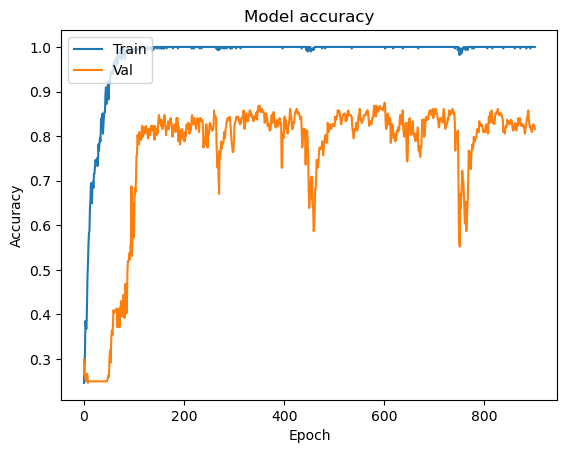

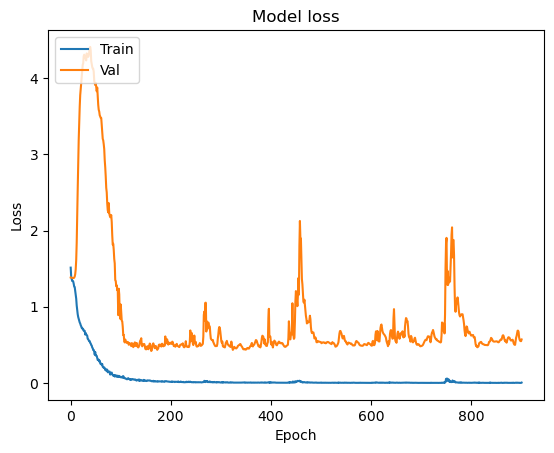


Training on subject  2
Epoch 935: early stopping
9/9 [==============================] - 2s 39ms/step
Subject: 2   Train no. 1   Time: 25.7 m   Test_acc: 0.6389   Test_kappa: 0.5185
9/9 [==============================] - 2s 67ms/step
Subject: 2   Train no. 2   Time: 25.4 m   Test_acc: 0.6562   Test_kappa: 0.5417
9/9 [==============================] - 2s 70ms/step
Subject: 2   Train no. 3   Time: 31.7 m   Test_acc: 0.6215   Test_kappa: 0.4954
----------
Subject: 2   best_run: 2   Time: 82.8 m   acc: 0.6562   avg_acc: 0.6389 +- 0.0142   kappa: 0.5417   avg_kappa: 0.5185 +- 0.0189
----------
Plot Learning Curves ....... 


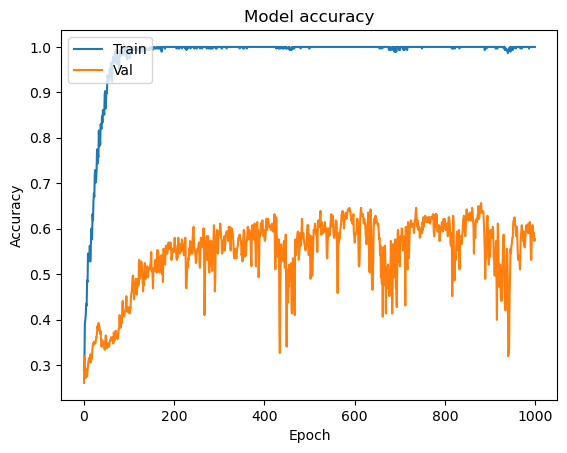

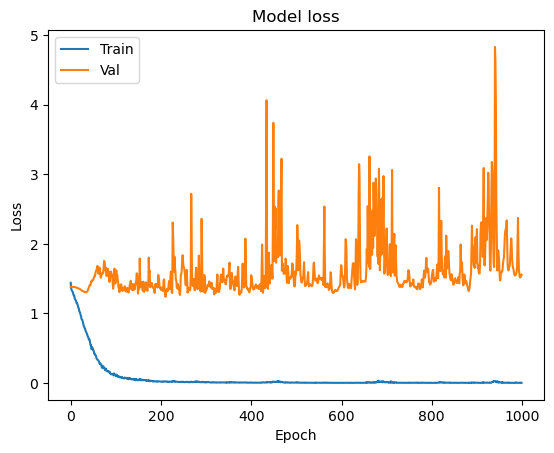


Training on subject  3
9/9 [==============================] - 3s 94ms/step
Subject: 3   Train no. 1   Time: 34.8 m   Test_acc: 0.9375   Test_kappa: 0.9167
Epoch 658: early stopping
9/9 [==============================] - 2s 56ms/step
Subject: 3   Train no. 2   Time: 23.4 m   Test_acc: 0.9236   Test_kappa: 0.8981
Epoch 826: early stopping
9/9 [==============================] - 4s 95ms/step
Subject: 3   Train no. 3   Time: 18.7 m   Test_acc: 0.9444   Test_kappa: 0.9259
----------
Subject: 3   best_run: 3   Time: 77.0 m   acc: 0.9444   avg_acc: 0.9352 +- 0.0087   kappa: 0.9259   avg_kappa: 0.9136 +- 0.0115
----------
Plot Learning Curves ....... 


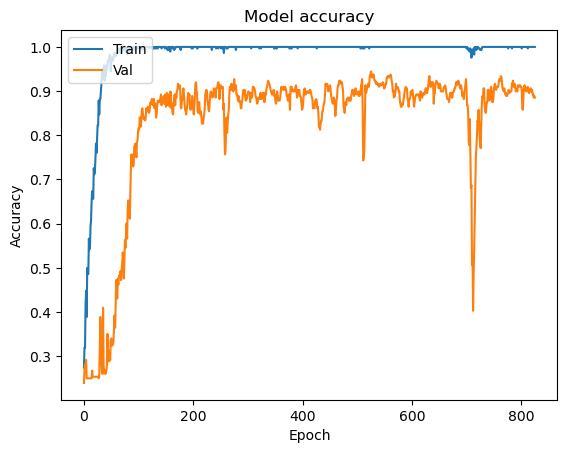

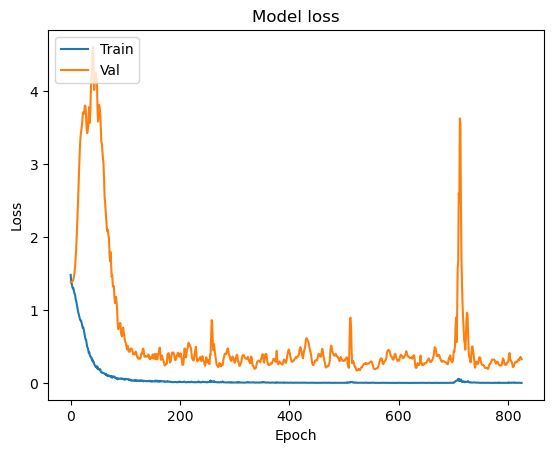


Training on subject  4
Epoch 885: early stopping
9/9 [==============================] - 2s 69ms/step
Subject: 4   Train no. 1   Time: 16.7 m   Test_acc: 0.6806   Test_kappa: 0.5741
Epoch 683: early stopping
9/9 [==============================] - 3s 79ms/step
Subject: 4   Train no. 2   Time: 12.5 m   Test_acc: 0.6632   Test_kappa: 0.5509
Epoch 602: early stopping
9/9 [==============================] - 2s 41ms/step
Subject: 4   Train no. 3   Time: 13.3 m   Test_acc: 0.6562   Test_kappa: 0.5417
----------
Subject: 4   best_run: 1   Time: 42.5 m   acc: 0.6806   avg_acc: 0.6667 +- 0.0102   kappa: 0.5741   avg_kappa: 0.5556 +- 0.0136
----------
Plot Learning Curves ....... 


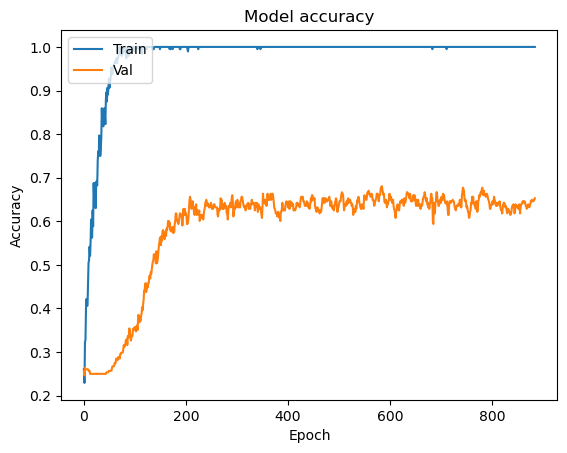

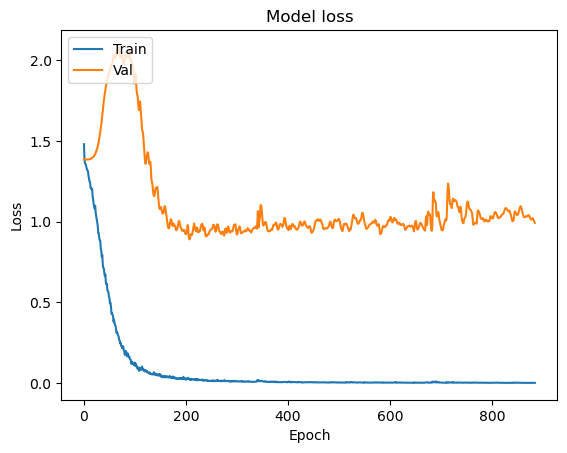


Training on subject  5
9/9 [==============================] - 2s 39ms/step
Subject: 5   Train no. 1   Time: 33.1 m   Test_acc: 0.6736   Test_kappa: 0.5648
9/9 [==============================] - 2s 41ms/step
Subject: 5   Train no. 2   Time: 28.3 m   Test_acc: 0.5972   Test_kappa: 0.4630
9/9 [==============================] - 2s 88ms/step
Subject: 5   Train no. 3   Time: 32.9 m   Test_acc: 0.6597   Test_kappa: 0.5463
----------
Subject: 5   best_run: 1   Time: 94.3 m   acc: 0.6736   avg_acc: 0.6435 +- 0.0332   kappa: 0.5648   avg_kappa: 0.5247 +- 0.0443
----------
Plot Learning Curves ....... 


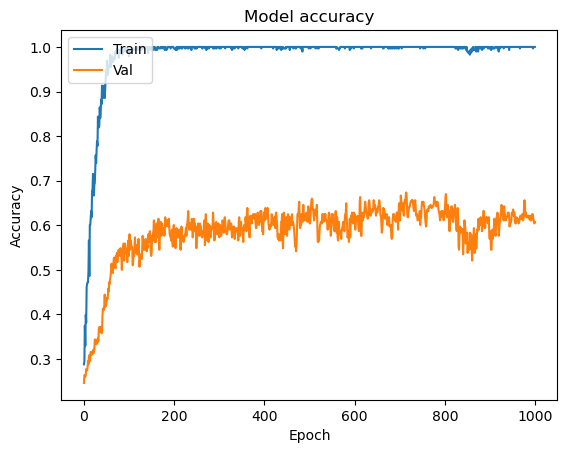

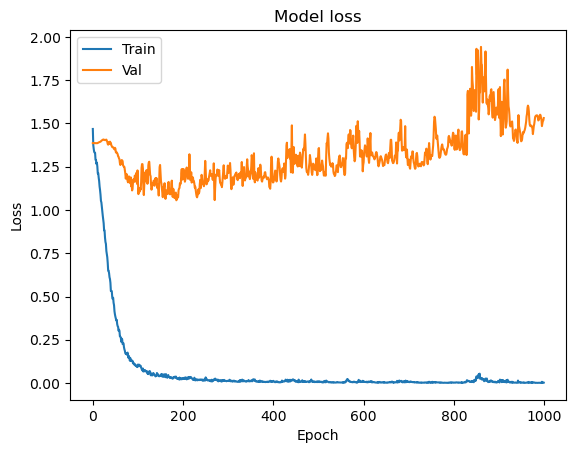


Training on subject  6
Epoch 909: early stopping
9/9 [==============================] - 2s 80ms/step
Subject: 6   Train no. 1   Time: 24.4 m   Test_acc: 0.6424   Test_kappa: 0.5231
9/9 [==============================] - 2s 81ms/step
Subject: 6   Train no. 2   Time: 33.7 m   Test_acc: 0.6493   Test_kappa: 0.5324
Epoch 866: early stopping
9/9 [==============================] - 3s 71ms/step
Subject: 6   Train no. 3   Time: 25.0 m   Test_acc: 0.7049   Test_kappa: 0.6065
----------
Subject: 6   best_run: 3   Time: 83.1 m   acc: 0.7049   avg_acc: 0.6655 +- 0.0280   kappa: 0.6065   avg_kappa: 0.5540 +- 0.0373
----------
Plot Learning Curves ....... 


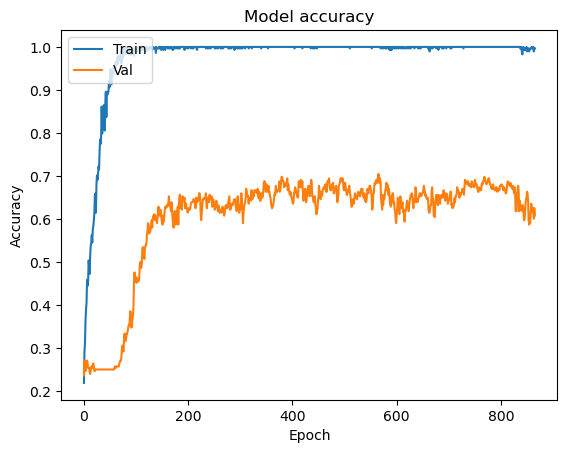

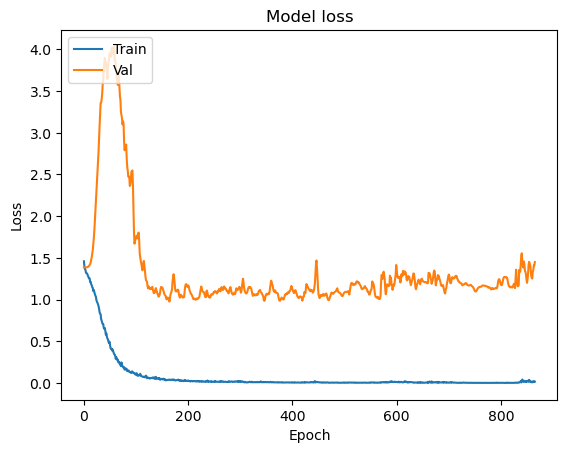


Training on subject  7
Epoch 445: early stopping
9/9 [==============================] - 3s 49ms/step
Subject: 7   Train no. 1   Time: 10.8 m   Test_acc: 0.8681   Test_kappa: 0.8241
9/9 [==============================] - 3s 72ms/step
Subject: 7   Train no. 2   Time: 38.3 m   Test_acc: 0.8750   Test_kappa: 0.8333
Epoch 721: early stopping
9/9 [==============================] - 2s 59ms/step
Subject: 7   Train no. 3   Time: 21.9 m   Test_acc: 0.8958   Test_kappa: 0.8611
----------
Subject: 7   best_run: 3   Time: 71.1 m   acc: 0.8958   avg_acc: 0.8796 +- 0.0118   kappa: 0.8611   avg_kappa: 0.8395 +- 0.0157
----------
Plot Learning Curves ....... 


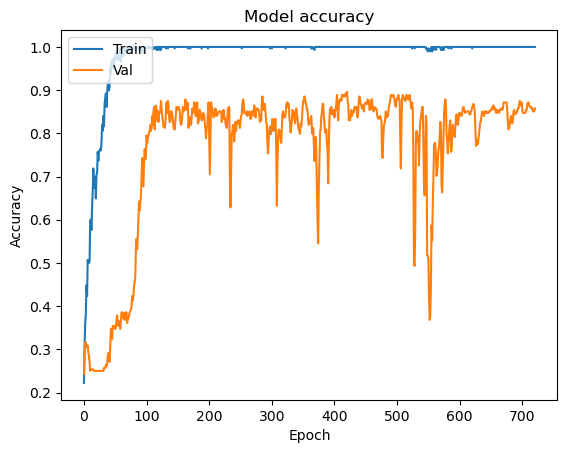

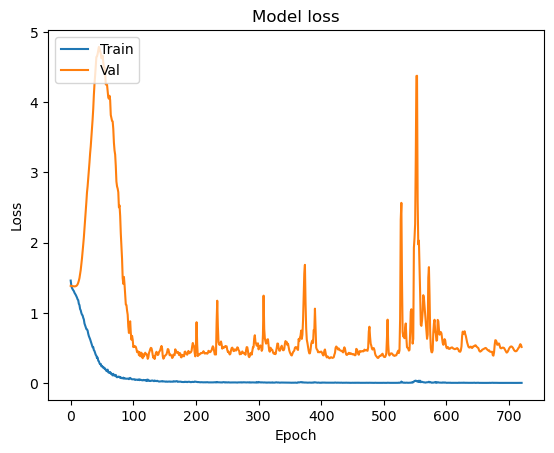


Training on subject  8
Epoch 580: early stopping
9/9 [==============================] - 2s 44ms/step
Subject: 8   Train no. 1   Time: 15.6 m   Test_acc: 0.8368   Test_kappa: 0.7824
Epoch 611: early stopping
9/9 [==============================] - 3s 56ms/step
Subject: 8   Train no. 2   Time: 20.7 m   Test_acc: 0.8264   Test_kappa: 0.7685
9/9 [==============================] - 3s 64ms/step
Subject: 8   Train no. 3   Time: 31.4 m   Test_acc: 0.8264   Test_kappa: 0.7685
----------
Subject: 8   best_run: 1   Time: 67.6 m   acc: 0.8368   avg_acc: 0.8299 +- 0.0049   kappa: 0.7824   avg_kappa: 0.7731 +- 0.0065
----------
Plot Learning Curves ....... 


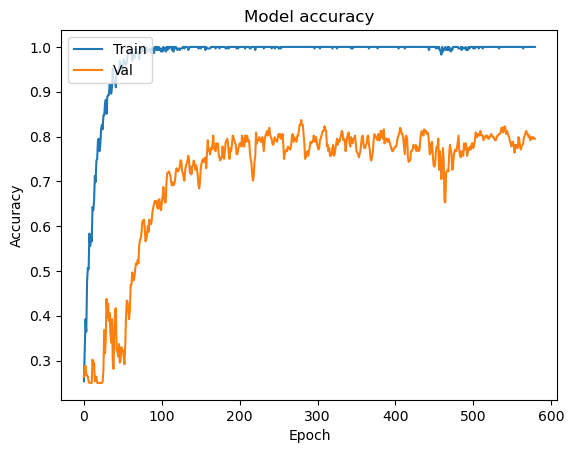

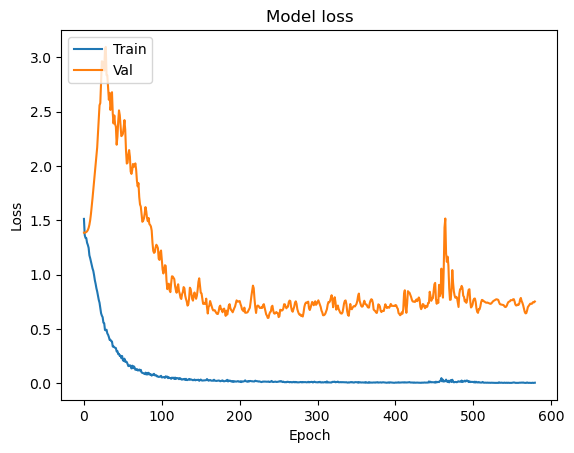


Training on subject  9
Epoch 884: early stopping
9/9 [==============================] - 3s 78ms/step
Subject: 9   Train no. 1   Time: 24.4 m   Test_acc: 0.8785   Test_kappa: 0.8380
Epoch 785: early stopping
9/9 [==============================] - 2s 90ms/step
Subject: 9   Train no. 2   Time: 21.6 m   Test_acc: 0.8889   Test_kappa: 0.8519
9/9 [==============================] - 2s 40ms/step
Subject: 9   Train no. 3   Time: 102.4 m   Test_acc: 0.8854   Test_kappa: 0.8472
----------
Subject: 9   best_run: 2   Time: 148.4 m   acc: 0.8889   avg_acc: 0.8843 +- 0.0043   kappa: 0.8519   avg_kappa: 0.8457 +- 0.0058
----------
Plot Learning Curves ....... 


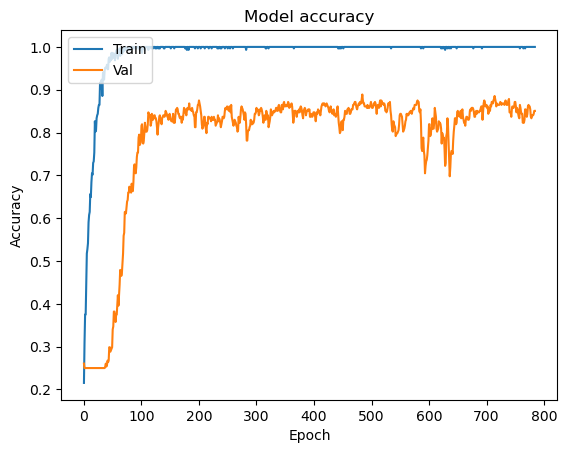

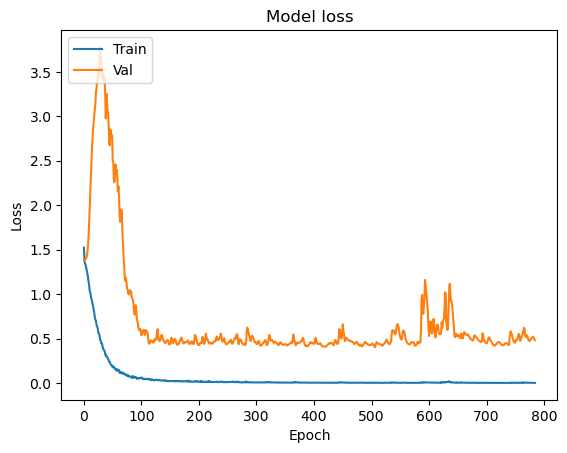


Time: 12.6 h   
9/9 [==============================] - 2s 35ms/step


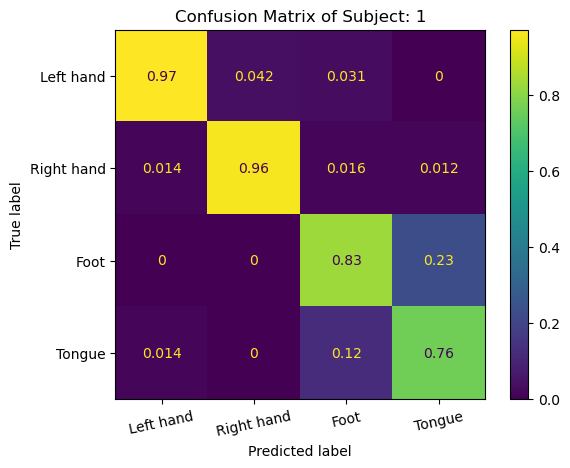

Subject: 1   best_run: 1   acc: 0.8750   kappa: 0.8333   avg_acc: 0.8507 +- 0.0186   avg_kappa: 0.8009 +- 0.0248
9/9 [==============================] - 0s 36ms/step


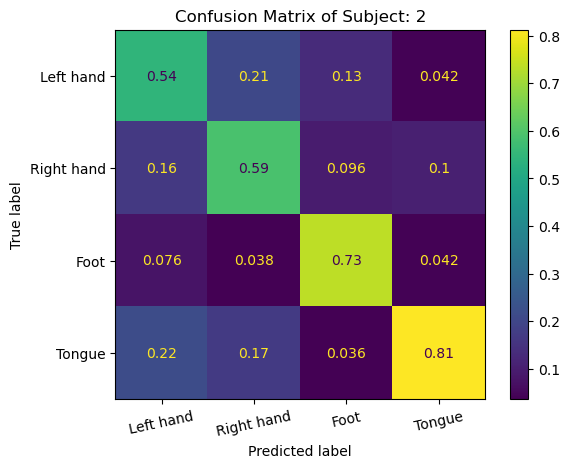

Subject: 2   best_run: 2   acc: 0.6562   kappa: 0.5417   avg_acc: 0.6389 +- 0.0142   avg_kappa: 0.5185 +- 0.0189
9/9 [==============================] - 0s 35ms/step


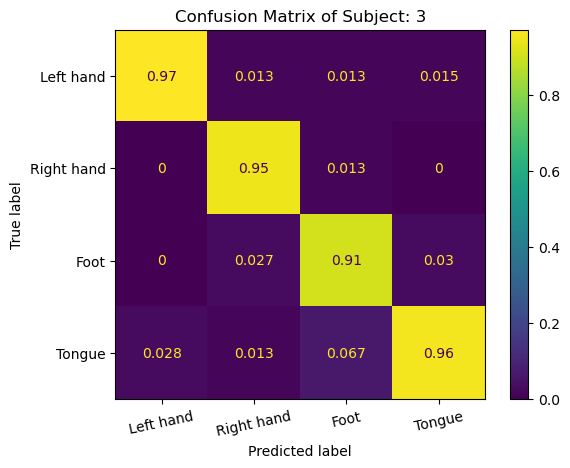

Subject: 3   best_run: 3   acc: 0.9444   kappa: 0.9259   avg_acc: 0.9352 +- 0.0087   avg_kappa: 0.9136 +- 0.0115
9/9 [==============================] - 0s 32ms/step


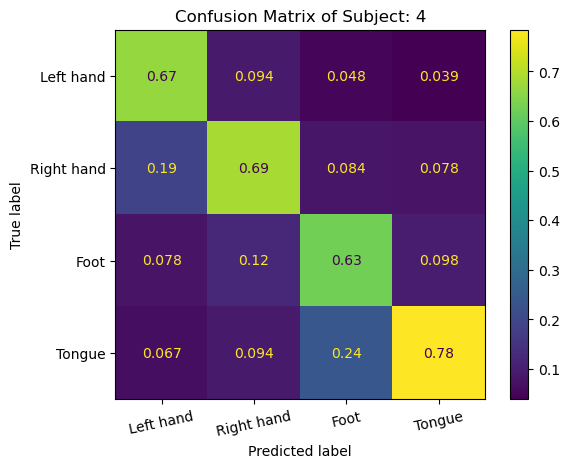

Subject: 4   best_run: 1   acc: 0.6806   kappa: 0.5741   avg_acc: 0.6667 +- 0.0102   avg_kappa: 0.5556 +- 0.0136
9/9 [==============================] - 0s 37ms/step


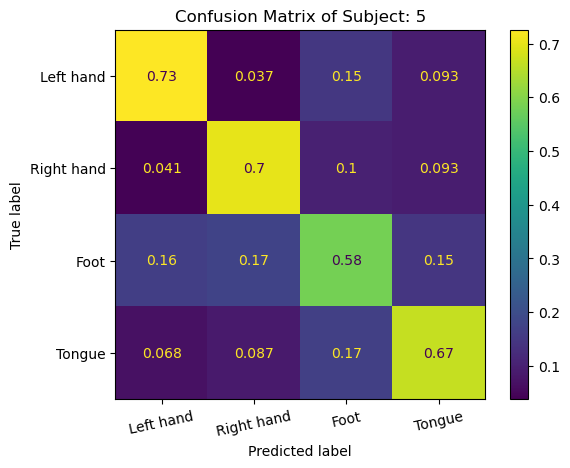

Subject: 5   best_run: 1   acc: 0.6736   kappa: 0.5648   avg_acc: 0.6435 +- 0.0332   avg_kappa: 0.5247 +- 0.0443
9/9 [==============================] - 0s 35ms/step


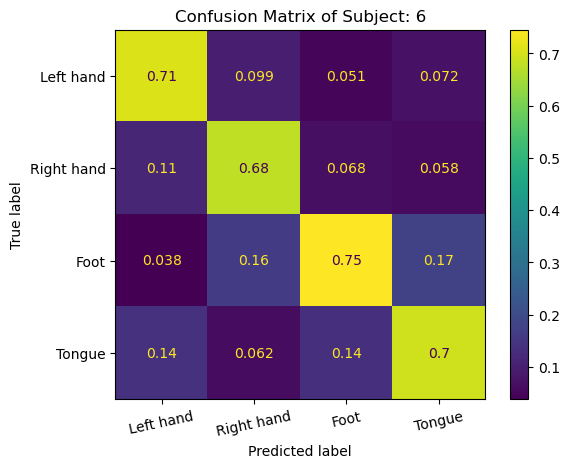

Subject: 6   best_run: 3   acc: 0.7049   kappa: 0.6065   avg_acc: 0.6655 +- 0.0280   avg_kappa: 0.5540 +- 0.0373
9/9 [==============================] - 0s 30ms/step


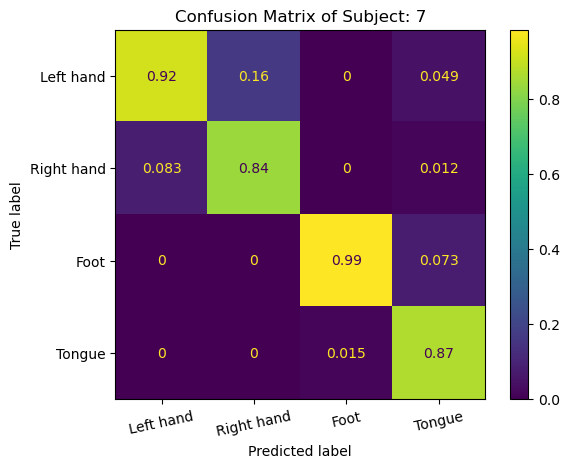

Subject: 7   best_run: 3   acc: 0.8958   kappa: 0.8611   avg_acc: 0.8796 +- 0.0118   avg_kappa: 0.8395 +- 0.0157
9/9 [==============================] - 0s 35ms/step


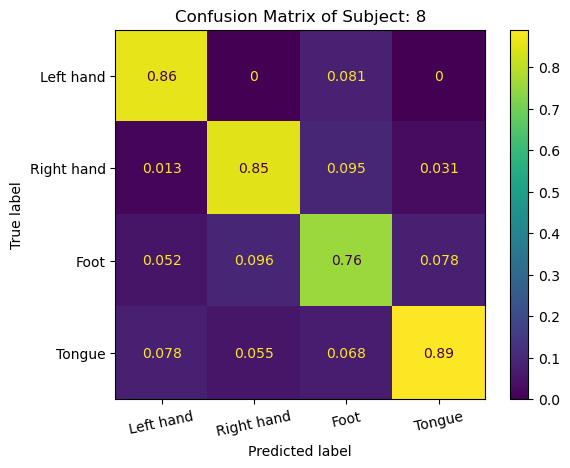

Subject: 8   best_run: 1   acc: 0.8368   kappa: 0.7824   avg_acc: 0.8299 +- 0.0049   avg_kappa: 0.7731 +- 0.0065
9/9 [==============================] - 0s 35ms/step


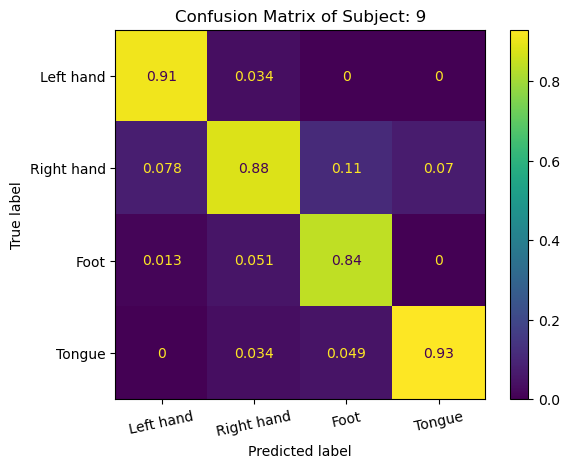

Subject: 9   best_run: 2   acc: 0.8889   kappa: 0.8519   avg_acc: 0.8843 +- 0.0043   avg_kappa: 0.8457 +- 0.0058

Average of 9 subjects - best runs:
Accuracy = 0.7951   Kappa = 0.7269

Average of 9 subjects x 3 runs (average of 27 experiments):
Accuracy = 0.7771   Kappa = 0.7028


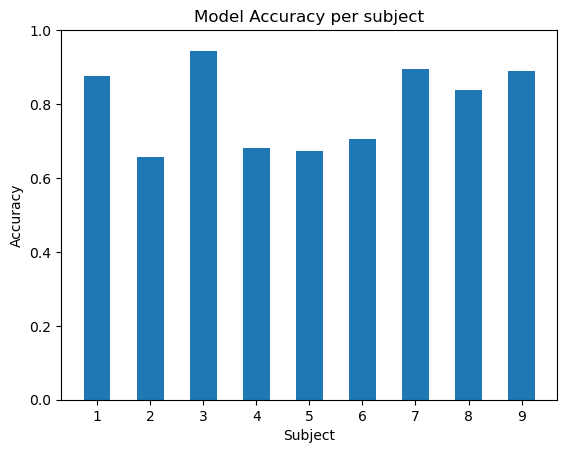

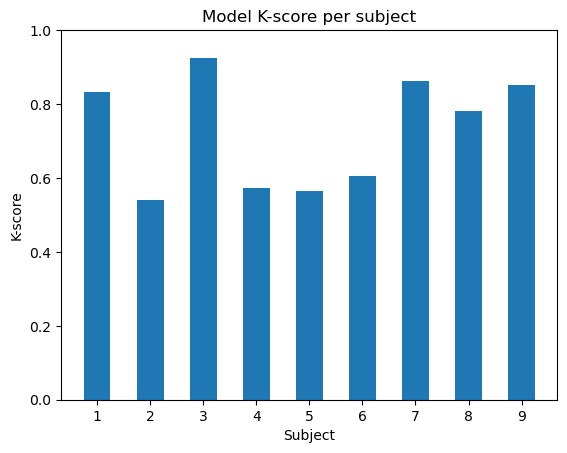

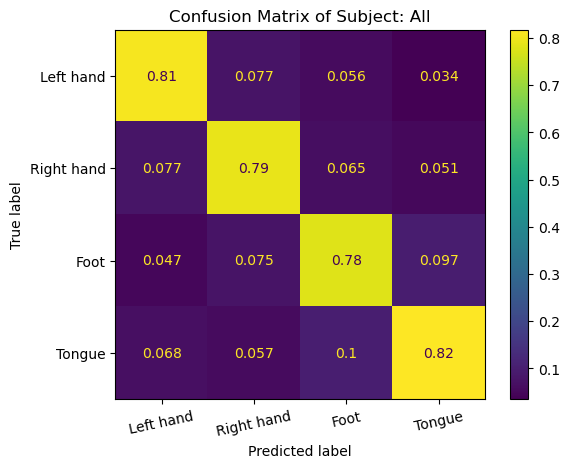

In [25]:
run()